In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.nn.functional as func
#torch.manual_seed(50)

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"


print(torch.__version__, torchvision.__version__)

1.12.1+cu113 0.13.1+cu113


/home/kjb/.conda/envs/lora/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dst = datasets.CIFAR100("~/.torch", download=True)
# dst = datasets.MNIST("~/.torch", download=True)

tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cpu


In [3]:
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#         nn.init.xavier_uniform_(m.weight.data)
#     if hasattr(m, "bias"):
#         #m.bias.data.uniform_(-0.5, 0.5)
#         #nn.init.xavier_uniform(m.bias.data)
#         m.bias.data.fill_(0)



# class LeNet(nn.Module):

#     def __init__(self):

#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5,stride=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=2)
#         self.fc1 = nn.Linear(16*5*5, 256)
#         self.fc2 = nn.Linear(256, 120)
#         self.fc3 = nn.Linear(120, 106)

#     def forward(self, x):
#         #x = func.relu(self.conv1(x))
#         x = func.sigmoid(self.conv1(x))
#         #x = func.max_pool2d(x, 2)
#         #x = func.relu(self.conv2(x))
#         x = func.sigmoid(self.conv2(x))
#         #x = func.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         #x = func.relu(self.fc1(x))
#         x = func.sigmoid(self.fc1(x))
#         #x = func.relu(self.fc2(x))
#         x = func.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

    
    
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.3, 0.3)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.3, 0.3)


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 106)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out


net = LeNet().to(device)
net.apply(weights_init)

criterion = cross_entropy_for_onehot

In [17]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
lfw_people=fetch_lfw_people(min_faces_per_person=14,color=True,slice_=(slice(61,189),slice(61,189)),resize=0.25)
x=lfw_people.images
y=lfw_people.target

target_names=lfw_people.target_names
n_classes=target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,shuffle=False)


# #two people
# X_train_two = []
# y_train_two = []
# X_test_two = []
# y_test_two = []
# for ct_d in range(X_train.shape[0]):
#     if  y_train[ct_d] == 6:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(1)
        
# for ct_d in range(X_test.shape[0]):
#     if  y_train[ct_d] == 6:        
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(1)
        
# X_train = np.asarray(X_train_two)    
# X_test = np.asarray(X_test_two)  
# y_train = np.asarray(y_train_two)  
# y_test = np.asarray(y_test_two)  

print (X_train.shape)
print (X_test.shape)

         
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
#X_train = torch.transpose
#X_train = X_train.astype('float32')
#X_train /= 255.0
#X_test /= 255.0

 


x_train = torch.FloatTensor(X_train).to(device)
x_train = x_train.transpose(2,3).transpose(1,2)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
x_test = x_test.transpose(2,3).transpose(1,2)
y_test = torch.LongTensor(y_test).to(device)


training = data.TensorDataset(x_train,y_train)

testing = data.TensorDataset(x_test,y_test)

dst_tensor=training

criterion_train = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
trainloader = torch.utils.data.DataLoader(training,batch_size=64, shuffle=True)

iter_ = 0
for epoch in range(0):

    for i,data in enumerate(trainloader,0):
   
        #if epoch>=1:
        if i>=2:
            break
        iter_=iter_+1
        #print (iter_)
        inputs,label = data
        
        inputs,label =  Variable(inputs),Variable(label) 
      
        optimizer_train.zero_grad()
        
    
        outputs_benign=net(inputs)
        #outputs_benign = F.softmax(outputs_benign, dim=-1)
        #print (outputs_benign[0])
     
        loss_benign =  criterion_train(outputs_benign,label)
       
        #print("loss computed")
        loss_benign.backward()
        #print("loss BP")
        optimizer_train.step()
        
        #if i%2000==0:
        print (loss_benign.item())
        #torch.save(net.state_dict(),'./LFW_net.pth')  
       
  
print ('fininshed training')
total = len(y_test)
acc =0.0
for ct in range(total):
    testing_data = tt(testing[ct][0].cpu())
    testing_data1 = tp(testing_data).to(device)
    testing_data2 = testing_data1.view(1, *testing_data1.size())
    y_pred = net(testing_data2)
    predicted = torch.argmax(y_pred)
  
    if predicted == y_test[ct]:
        acc=acc+1
accuracy = acc / total
print (accuracy)
print ('fininshed testing')

(2801, 32, 32, 3)
(934, 32, 32, 3)
fininshed training
0.008565310492505354
fininshed testing


tensor([[[0.2941, 0.4275, 0.8471,  ..., 0.4078, 0.2353, 0.2980],
         [0.3098, 0.6745, 0.8902,  ..., 0.4784, 0.2392, 0.2588],
         [0.4706, 0.8353, 0.8471,  ..., 0.5098, 0.2706, 0.2431],
         ...,
         [0.1216, 0.1765, 0.1725,  ..., 0.2353, 0.2627, 0.2745],
         [0.1412, 0.1922, 0.1961,  ..., 0.2392, 0.2941, 0.2510],
         [0.1569, 0.2078, 0.2078,  ..., 0.2392, 0.2706, 0.2353]],

        [[0.3490, 0.4667, 0.8627,  ..., 0.4784, 0.2824, 0.2196],
         [0.3608, 0.7059, 0.9020,  ..., 0.5647, 0.3098, 0.2157],
         [0.4980, 0.8510, 0.8471,  ..., 0.5922, 0.3412, 0.2118],
         ...,
         [0.1725, 0.2196, 0.2157,  ..., 0.4157, 0.4157, 0.3294],
         [0.1961, 0.2471, 0.2392,  ..., 0.4275, 0.3922, 0.2471],
         [0.2078, 0.2667, 0.2510,  ..., 0.4235, 0.3490, 0.1961]],

        [[0.3882, 0.4941, 0.8627,  ..., 0.6392, 0.3255, 0.0902],
         [0.3922, 0.7333, 0.9020,  ..., 0.6824, 0.3843, 0.1137],
         [0.5216, 0.8745, 0.8431,  ..., 0.6784, 0.4549, 0.

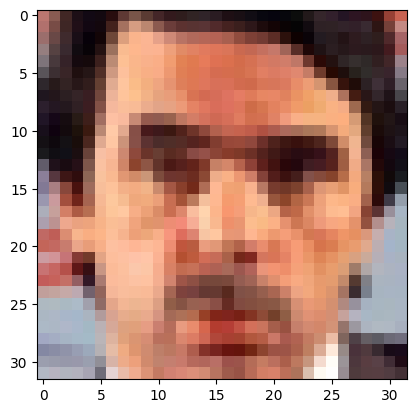

In [18]:
print(x_train[0])
print(dst_tensor[0][0].cpu())
plt.imshow(tt(dst_tensor[img_index][0].cpu()))

torch.Size([1, 3, 32, 32])
GT label is 57. 
Onehot label is 57.


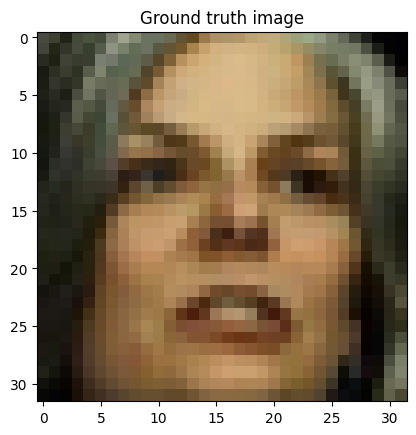

In [19]:


######### honest partipant #########
img_index = 75   #use img_index
dst_pil = tt(dst_tensor[img_index][0].cpu())   #use img_index

gt_data = tp(dst_pil).to(device)
gt_data = torch.unsqueeze(gt_data,0)

batch = 1  #
for bat in range(batch-1):
    dst_pil = tt(dst_tensor[img_index+1+bat][0].cpu())   #use img_index
    tmp = torch.unsqueeze(tp(dst_pil).to(device),0)
    print(tmp.shape)
    gt_data = torch.cat((gt_data,tmp),0)


print (gt_data.shape)
#gt_data = gt_data.view(1, *gt_data.size())
#gt_label = torch.Tensor([dst_pil[img_index][1]]).long().to(device)  #use img_index
gt_label = dst_tensor[img_index][1].long().to(device) #use img_index
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=106)



plt.imshow(dst_pil)
#plt.savefig("./attack_image/original")

plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 92.


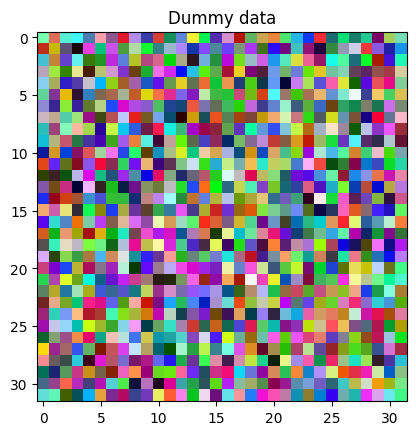

In [20]:
# generate dummy data and label
torch.manual_seed(1000)
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

#aaa = torch.rand([3,16,16])
#bbb = torch.cat((aaa,aaa),dim=1)
#ccc = torch.cat((bbb,bbb),dim=2)
#dummy_data = torch.unsqueeze(ccc,dim=0).to(device).requires_grad_(True)


plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())



14.68177032
1.93621540
0.63100839
0.20046760
0.07006162
0.02591615
0.01109367
0.00526060
0.00259830
0.00139692
0.00077326
0.00043514
0.00023961
0.00013151
0.00007231
0.00004418
0.00002760
0.00001781
0.00001195
0.00000869
0.00000649
0.00000505
0.00000417
0.00000369
0.00000340
0.00000334
0.00000323
0.00000321
0.00000318
0.00000311
0.00000307
0.00000304
0.00000303
0.00000298
0.00000293
0.00000290
0.00000289
0.00000286
0.00000284
0.00000281
0.00000276
0.00000276
0.00000274
0.00000272
0.00000272
0.00000268
0.00000267
0.00000266
0.00000264
0.00000263
0.00000261
0.00000259
0.00000258
0.00000257
0.00000254
0.00000252
0.00000251
0.00000250
0.00000248
0.00000247


FileNotFoundError: [Errno 2] No such file or directory: '/home/kjb/nwdaf/CPL_attack/DLG/attack_image/random.png'

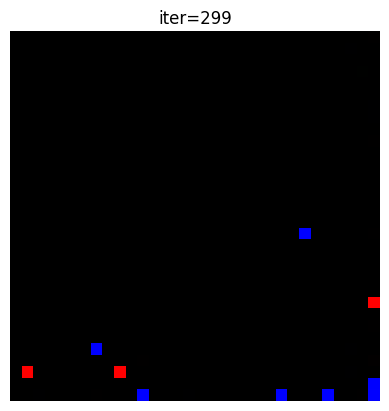

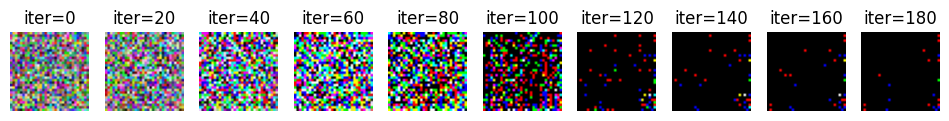

In [7]:
from pytorch_msssim import ssim

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
history_batch = []

percept_dis = np.zeros(300)
recover_dis = np.zeros(300)
for iters in range(300):
    
    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("iter=%d" % (iters))
    plt.axis('off')
    
    percept_dis[iters]=ssim(dummy_data.cpu(),gt_data,data_range=0).item()
    recover_dis[iters]=torch.dist(dummy_data.cpu(),gt_data,2).item()
    
        
    #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    #plt.savefig("./attack_image/gif_iters_%s_label_%s"%(iters,torch.argmax(dummy_label, dim=-1).item()))
    #plt.clf()
    
    
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        
        #print (pred.shape)
        #print (dummy_onehot_label)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
        #print (dummy_dy_dp[0].shape)
        
        grad_diff = 0
        grad_count = 0
        count =0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            
            
            grad_count += gx.nelement()
            
            #if count == 9:
            #    break
            count=count+1
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        #print (count)
        
        #print (dummy_dy_dx)
        #print (original_dy_dx)
        
        
        return grad_diff
    

       
    optimizer.step(closure)
    if iters % 5 == 0: 
        current_loss = closure()
        print ("%.8f" % current_loss.item())
        #print(iters, "%.8f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))
    
   
plt.figure(figsize=(12, 1.5))
iter_idx = [0,20,40,60,80,100,120,140,160,180]
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(history[iter_idx[i]])
  plt.title("iter=%d" % (iter_idx[i]))
  plt.axis('off')
plt.savefig("./attack_image/random.png")

    
    
#np.savetxt('ssim_dlg.out',percept_dis,fmt="%4f")
#np.savetxt('mse_ours.out',recover_dis,fmt="%4f")

    
#     for bat in range(batch-1):
#         history_batch.append(tt(dummy_data[bat].cpu()))
    

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history[i * 5])
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
plt.figure(figsize=(12, 8))
for j in range(batch):
    for i in range(60):
      plt.subplot(6, 10, i + 1)
      plt.imshow(history_batch[i * 5+j])
      plt.title("iter=%d" % (i * 5+ j))
      plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())